In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
#using NearestNeighbors # Can't use KDtree in julia for posterior prediction

In [2]:
#using Pkg
#Pkg.add("RData")

In [3]:
include("../../util2.j")

colnorm (generic function with 1 method)

In [4]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables
using Dates
using StatsBase

In [5]:
#using Pkg
#Pkg.add("StatsBase");
#using NearestNeighborDescent

In [6]:
using RData
objs = load("../data/rawdata/raw_data.RData", convert = true)

Dict{String,Any} with 1 entry:
  "raw_data" => 5760000×31 DataFrame. Omitted printing of 26 columns…

In [7]:
replace!(objs["raw_data"].LC_Type4, 255=>missing); # change fill number 255 into missing

In [8]:
# pick responses: NDVI EVI
# pick explanatory variables: view zenith angle, sun zenith angle, 
#                             relative azimuth angle, composite day of the year, 
#                             land cover (LC_type3 or 4, fill number 255), GPP
# take off the NA data
data_conj = filter(row -> !ismissing(row.EVI), 
    objs["raw_data"][:, [:scaled_x, :scaled_y, :NDVI, :EVI, :view_zenith_angle, 
            :sun_zenith_angle, :relative_azimuth_angle, :composite_day_of_the_year, 
            :LC_Type4, :GPP, :LW]]);
data_conj = filter!(row -> !ismissing(row.LC_Type4), 
    data_conj);
data_conj = filter!(row -> !ismissing(row.relative_azimuth_angle), data_conj);
data_conj = filter!(row -> !ismissing(row.GPP), data_conj);
data_conj = filter!(row -> row.LW == 2.0, data_conj);

In [9]:
describe(data_conj)

MethodError: MethodError: no method matching describe(::DataFrame)
Closest candidates are:
  describe(!Matched::AbstractArray) at /home/lu/.julia/packages/StatsBase/OyeLC/src/scalarstats.jl:651
  describe(!Matched::IO, !Matched::AbstractArray{T<:Union{Missing, Real},N} where N) where T<:Union{Missing, Real} at /home/lu/.julia/packages/StatsBase/OyeLC/src/scalarstats.jl:653
  describe(!Matched::IO, !Matched::AbstractArray) at /home/lu/.julia/packages/StatsBase/OyeLC/src/scalarstats.jl:657
  ...

In [31]:
countmap(data_conj.LC_Type4)

Dict{Union{Missing, Float64},Int64} with 8 entries:
  7.0 => 749598
  4.0 => 107056
  0.0 => 1107
  2.0 => 35896
  5.0 => 118838
  8.0 => 104373
  6.0 => 1181461
  1.0 => 2195956

Summary Stats:
Length:         5760000
Missing Count:  0
Mean:           1.781990
Minimum:        1.000000
1st Quartile:   2.000000
Median:         2.000000
3rd Quartile:   2.000000
Maximum:        2.000000
Type:           Float64


In [45]:
save("../data/conj_data.jld", data_conj)

ErrorException: Must supply a name for each variable

In [25]:
# coordinate:
coords_ord = [data_conj.scaled_x data_conj.scaled_y];
n = size(coords_ord)[1]; S = 1:n; m = 10;
X_ord = [fill(1.0, n) data_conj.GPP];
Y_ord = [data_conj.NDVI data_conj.EVI];

In [26]:
Dates.format(now(), "HH:MM:SS")  

"00:05:11"

In [27]:
# build neighbors #
m = 10;                                                       # number of nearest neighbor                       
NN = BuildNN(coords_ord, m, 1.0, 0.0);                       # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:n);                            # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):n, inner = m), 1:n);  # the index of rows

In [28]:
Dates.format(now(), "HH:MM:SS")  

"03:42:05"

In [38]:
describe(NN)

MethodError: MethodError: no method matching describe(::NamedTuple{(:nnIndx, :nnDist, :nnIndxLU),Tuple{Array{Int64,1},Array{Float64,1},Array{Int64,1}}})
Closest candidates are:
  describe(!Matched::AbstractArray) at /home/lu/.julia/packages/StatsBase/OyeLC/src/scalarstats.jl:651
  describe(!Matched::IO, !Matched::AbstractArray{T<:Union{Missing, Real},N} where N) where T<:Union{Missing, Real} at /home/lu/.julia/packages/StatsBase/OyeLC/src/scalarstats.jl:653
  describe(!Matched::IO, !Matched::AbstractArray) at /home/lu/.julia/packages/StatsBase/OyeLC/src/scalarstats.jl:657
  ...

In [39]:
save("../data/conj_NN.jld", "nnIndx_col", nnIndx_col, "nnIndx_row", nnIndx_row, 
    "nnDist", NN.nnDist, "nnIndxLU", NN.nnIndxLU)

In [42]:
#NN2 = load("../data/conj_NN.jld")
#NN2["nnDist"]

Dict{String,Any} with 4 entries:
  "nnIndx_row" => [2, 3, 3, 4, 4, 4, 5, 5, 5, 5  …  4508722, 4508723, 4508724, …
  "nnIndxLU"   => [1, 1, 2, 4, 7, 11, 16, 22, 29, 37  …  45087166, 45087176, 45…
  "nnIndx_col" => [1, 2, 1, 3, 2, 1, 4, 3, 2, 1  …  4508722, 4508723, 4508724, …
  "nnDist"     => [0.000463313, 0.000463313, 0.000926625, 0.000463313, 0.000926…

45087255-element Array{Float64,1}:
 0.000463312716527842  
 0.000463312716527842  
 0.000926625433055684  
 0.00046331271652784195
 0.0009266254330556839 
 0.001389938149583526  
 0.0004633127165283076 
 0.0009266254330561496 
 0.0013899381495839915 
 0.0018532508661118336 
 0.00046331271652784185
 0.0009266254330561495 
 0.0013899381495839913 
 ⋮                     
 0.0010359987289964435 
 0.0013104462546673155 
 0.0004633127165269979 
 0.0004633127165278861 
 0.0006552231273330297 
 0.0009266254330557722 
 0.0009266254330557722 
 0.0010359987289960465 
 0.0010359987289964435 
 0.0013104462546673155 
 0.001389938149582548  
 0.0013899381495836582 

In [33]:
# priors #
p = 2; q = 2
μβ = fill(0.0, p, q); inv_Vr =[[0.0 0.0]; [0.0 0.0]]; # set Vr^{-1} be zero for the simulation...
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];


In [15]:
# cross-validation Preparison
# (a) Randomly split S into K folder 
Random.seed!(321);
kf = 5;
parts = kfoldperm(n,kf);

# (b) Build NN index for training data in ith folder
using RCall
CVNN_train = Array{Any,1}(undef, kf);
CVNN_test = Array{Any,1}(undef, kf);
CVnnIndx_col = Array{Any,1}(undef, kf);
CVnnIndx_row = Array{Any,1}(undef, kf);
CVMnnIndxLU = Array{Any,1}(undef, kf); 
CVMnnIndx = Array{Any,1}(undef, kf);

@rput coords_ord
@rput S
@rput m
@rput parts
prog = Progress(kf, 1, "Computing initial pass...", 50)
for i in 1:kf 
    # Build NN index for training data in ith folder
    CVNN_train[i] = BuildNN(coords_ord[S[filter(x->!(x in parts[i]), eachindex(S))], :], m);
    CVnnIndx_col[i] = vcat(CVNN_train[i].nnIndx, 1:(n - length(parts[i])));
    CVnnIndx_row[i] = zeros(Int64, 0);
    for j in 2:m
        CVnnIndx_row[i] = vcat(CVnnIndx_row[i], fill(j, j-1));
    end
    CVnnIndx_row[i] = vcat(CVnnIndx_row[i], 
        repeat((m + 1):(n - length(parts[i])), inner = m), 1:(n - length(parts[i])));
        
    # Build nearest neighbor index for holdout locations
    @rput i
    R"""
    library("RANN")
    nn_mod_ho <- nn2(coords_ord[S[-parts[[i]]], ], coords_ord[S[parts[[i]]], ], k = m)
    """
    @rget nn_mod_ho
    CVNN_test[i] = nn_mod_ho;
    CVMnnIndxLU[i] = collect(1:m:(length(parts[i]) * m + 1));
    CVMnnIndx[i] = vec(nn_mod_ho[:nn_idx]'); 
    next!(prog)
end   

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840
Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:02


In [17]:
S[filter(x->!(x in parts[1]), eachindex(S))]

8000-element Array{Int64,1}:
    1
    2
    3
    5
    6
    7
    8
    9
   10
   11
   13
   15
   17
    ⋮
 9986
 9987
 9988
 9989
 9990
 9991
 9993
 9995
 9996
 9997
 9998
 9999

In [16]:
CVNN_train

5-element Array{Any,1}:
 (nnIndx = [1, 2, 948, 949, 3, 2, 4, 950, 949, 3  …  7999, 7033, 7998, 7032, 6088, 6087, 7997, 5142, 7031, 6086], nnDist = [0.000463313, 0.000463313, 0.000655223, 0.000655223, 0.000926625, 0.00138994, 0.000463313, 0.000655223, 0.001036, 0.00138994  …  0.000463313, 0.000655223, 0.000926625, 0.001036, 0.001036, 0.00131045, 0.00138994, 0.00146512, 0.00146512, 0.0016705], nnIndxLU = [1, 1, 2, 4, 7, 11, 16, 22, 29, 37  …  79856, 79866, 79876, 79886, 79896, 79906, 79916, 79926, 79936, 79946])  
 (nnIndx = [1, 947, 2, 3, 948, 1916, 4, 3, 948, 1917  …  7999, 7077, 7998, 6125, 6124, 7997, 7076, 6123, 7996, 4248], nnDist = [0.000463313, 0.000655223, 0.000926625, 0.000463313, 0.000655223, 0.001036, 0.000463313, 0.000926625, 0.001036, 0.001036  …  0.000463313, 0.000655223, 0.000926625, 0.001036, 0.00131045, 0.00138994, 0.00146512, 0.0016705, 0.00185325, 0.00191029], nnIndxLU = [1, 1, 2, 4, 7, 11, 16, 22, 29, 37  …  79856, 79866, 79876, 79886, 79896, 79906, 79916, 79926, 799

In [18]:
# (a) grid of candidate value
ϕ_grid = vcat(LinRange(3 / sqrt(2), 3 * 12.5 / sqrt(2), 25))
#LinRange(3 / sqrt(2), 3 * 50 / sqrt(2), 20) #LinRange(3 / sqrt(2), 3 * 100 / sqrt(2), 20);
α_grid = vcat(LinRange(0.8, 0.99, 25)) #LinRange(0.75, 1, 10); #LinRange(0.5, 1, 10);

In [19]:
# For loop
CVRMSPE = fill(0.0, length(ϕ_grid), length(α_grid));
prog = Progress(kf, 1, "Computing initial pass...", 50)
#for i in 1:kf
i = 1
    CVnIndx = length(CVNN_train[i].nnIndx);
    nk = length(parts[i]);
    CVA = Array{Float64}(undef, CVnIndx); CVD = Array{Float64}(undef, n - nk);
    Index_train = [filter(x->!(x in parts[i]), eachindex(S))][1];
    CVDI_AX = []; CVDI_AY = []; CVVstar = []; CVμstar = [];
    
    CVAtilde = Array{Float64}(undef, nk * m); CVDtilde = Array{Float64}(undef, nk);
    CVAtildeM = [];
    
    for j in 1:length(ϕ_grid) 
        for k in 1:length(α_grid)
            
            # obtain posterior estimators of beta
            getAD_collapse(coords_ord[S[Index_train], :], 
                CVNN_train[i].nnIndx, CVNN_train[i].nnDist, CVNN_train[i].nnIndxLU, 
                ϕ_grid[j], 0.5, α_grid[k], CVA, CVD);
            CVDI_AX = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], CVnnIndx_col[i], 
                    vcat(-CVA, ones(n - nk))) * X_ord[S[Index_train], :]);
            CVDI_AY = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], CVnnIndx_col[i], 
                    vcat(-CVA, ones(n - nk))) * Y_ord[S[Index_train], :]);
            CVVstar = inv(Symmetric(CVDI_AX'CVDI_AX + inv_Vr));
            CVμstar = CVVstar * (CVDI_AX'CVDI_AY + inv_Vr * μβ);
            
            # obtain posterior predictions over holded folder
            getAD_collapse(coords_ord[S[Index_train], :], CVMnnIndx[i], 
                vec(CVNN_test[i][:nn_dists]'), CVMnnIndxLU[i],  ϕ_grid[j], 0.5, α_grid[k], CVAtilde, CVDtilde)
            CVAtildeM = sparse(repeat(1:nk, inner = m), CVMnnIndx[i], CVAtilde, nk, n - nk);
            Y_hold_mean = X_ord[S[parts[i]], :] * CVμstar + 
                CVAtildeM * (Y_ord[S[Index_train], :] - X_ord[S[Index_train], :] * CVμstar);
            
            # Calculate RMSPE
            CVRMSPE[j, k] = CVRMSPE[j, k] + sqrt(mean((Y_ord[S[parts[i]], :] - Y_hold_mean).^2));
        end
    end
#   next!(prog) # monitor the progress
#end


DomainError: DomainError with -7.49144092350285:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [32]:
describe(deleteat!(CVD, 5682))

Summary Stats:
Length:         7999
Missing Count:  0
Mean:           0.270456
Minimum:        -7.536796
1st Quartile:   0.276827
Median:         0.277060
3rd Quartile:   0.277586
Maximum:        1.250000
Type:           Float64


In [36]:
filter( x -> x < 0, CVD)

8-element Array{Float64,1}:
 -7.49144092350285  
 -7.507138006689372 
 -6.213627964312879 
 -7.5210195512562645
 -7.531108729527032 
 -6.237450475416489 
 -7.5367961542751   
 -6.2373411010205935

In [33]:
?filter

search: filter filter! fieldtype fieldtypes



```
filter(f, a::AbstractArray)
```

Return a copy of `a`, removing elements for which `f` is `false`. The function `f` is passed one argument.

# Examples

```jldoctest
julia> a = 1:10
1:10

julia> filter(isodd, a)
5-element Array{Int64,1}:
 1
 3
 5
 7
 9
```

---

```
filter(f, d::AbstractDict)
```

Return a copy of `d`, removing elements for which `f` is `false`. The function `f` is passed `key=>value` pairs.

# Examples

```jldoctest
julia> d = Dict(1=>"a", 2=>"b")
Dict{Int64,String} with 2 entries:
  2 => "b"
  1 => "a"

julia> filter(p->isodd(p.first), d)
Dict{Int64,String} with 1 entry:
  1 => "a"
```

---

```
filter(function, df::AbstractDataFrame)
```

Return a copy of data frame `df` containing only rows for which `function` returns `true`. The function is passed a `DataFrameRow` as its only argument.

# Examples

```
julia> df = DataFrame(x = [3, 1, 2, 1], y = ["b", "c", "a", "b"])
4×2 DataFrame
│ Row │ x     │ y      │
│     │ Int64 │ String │
├─────┼───────┼────────┤
│ 1   │ 3     │ b      │
│ 2   │ 1     │ c      │
│ 3   │ 2     │ a      │
│ 4   │ 1     │ b      │

julia> filter(row -> row[:x] > 1, df)
2×2 DataFrame
│ Row │ x     │ y      │
│     │ Int64 │ String │
├─────┼───────┼────────┤
│ 1   │ 3     │ b      │
│ 2   │ 2     │ a      │
```


In [10]:
# cross-validation for choosing delta and phi ...
pick_ind = argmin(CVRMSPE);
ϕ_pick = ϕ_grid[pick_ind[1]]; α_pick = α_grid[pick_ind[2]]; # alpha ranges from 0 to 1. alpha = sigma2 / (sigma2 + tau2)
[ϕ_pick, α_pick]

2-element Array{Float64,1}:
 4.1542523394709665
 0.9029166666666667

In [11]:
#ϕ_pick = ϕ1; α_pick = α;

In [12]:
# Build μ* V* Ψ* v*
nIndx = length(NN.nnIndx);
A = Array{Float64}(undef, nIndx); D = Array{Float64}(undef, n);
getAD_collapse(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_pick, 0.5, α_pick, A, D);
DI_AX = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(n))) * X_ord[S, :]);
DI_AY = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(n))) * Y_ord[S, :]);
Vstar = inv(Symmetric(DI_AX'DI_AX + inv_Vr));
μstar = Vstar * (DI_AX'DI_AY + inv_Vr * μβ);
Lμstar = cholesky(Vstar).L \ μstar;
Ψstar = ΨΣ + DI_AY'DI_AY + transpose(μβ) * inv_Vr * μβ - Lμstar'Lμstar;
νstar = νΣ + n;
Lstar = cholesky(Vstar);

In [13]:
# construct Atilde Dtilde #

using RCall
@rput coords_ord
@rput S
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(t(coords_ord[, S]), t(coords_ord[, -S]), k = m)
"""
@rget nn_mod_ho
nm = length(M);
Atilde = Array{Float64}(undef, nm * m); Dtilde = Array{Float64}(undef, nm);
MnnIndxLU = collect(1:m:(nm * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');
getAD_collapse(coords_ord[:, S], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, 
    ϕ_pick, 0.5, α_pick, Atilde, Dtilde)
AtildeM = sparse(repeat(1:nm, inner = m), MnnIndx, Atilde, nm, n);

In [14]:
# Preallocation for posterior samples #
N_sam = 500;
β_sam = Array{Float64, 3}(undef, p, q, N_sam);
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam);
Y_m_sam = Array{Float64, 3}(undef, length(M), q, N_sam);   # missing value

cholΣ_sam = Array{Float64, 2}(undef, q, q);

In [15]:
# generate the posterior samples #
Random.seed!(123);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    Σ_sam[:, :, l] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    cholΣ_sam = cholesky(Σ_sam[:, :, l]);
    β_sam[:, :, l] = (Lstar.L * rand(Normal(), p, q)) * 
                    cholΣ_sam.U + μstar;          # sample γ  
    Y_m_sam[:, :, l] = X_ord[M, :] * β_sam[:, :, l] + 
    AtildeM * (Y_ord[S, :] - X_ord[S, :]* β_sam[:, :, l] ) + 
    Diagonal(sqrt.(Dtilde)) * rand(Normal(), nm, q) * cholΣ_sam.U
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:02


# MCMC Chain check

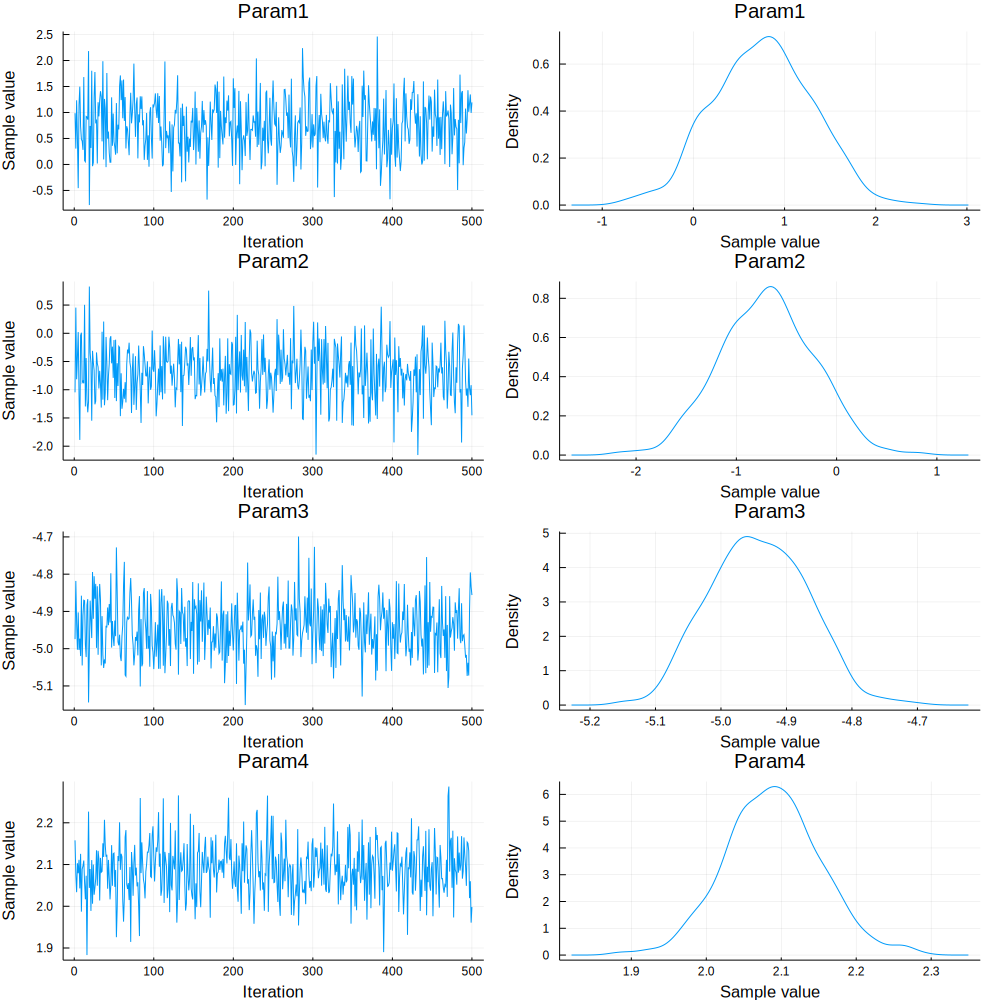

In [16]:
β_pos_sam = Array{Float64, 3}(undef, N_sam, p * q, 1);
β_pos_sam[:, :, 1] = hcat(β_sam[1, 1, :], β_sam[1, 2, :], β_sam[2, 1, :], β_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

In [17]:
β

2×2 Array{Float64,2}:
  1.0  -1.0
 -5.0   2.0

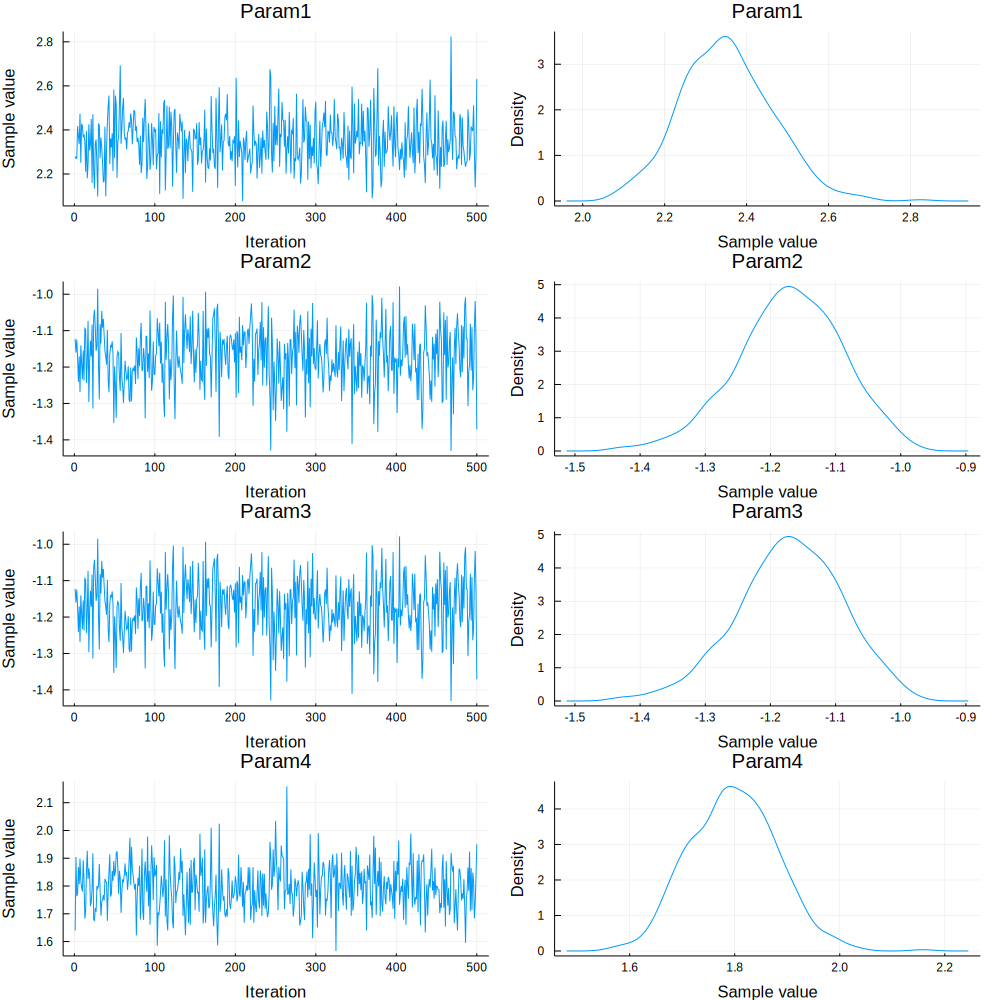

In [18]:
truncindex = 1;#Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[1, 2, truncindex:N_sam], 
    Σ_sam[2, 1, truncindex:N_sam], Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [19]:
Σ

2×2 Array{Float64,2}:
  2.0  -1.0
 -1.0   1.5

# Posterior Inference 

In [20]:
N_Inf_burn = 1;
Y_m_pos_qt = Array{Float64, 3}(undef, nm, q, 3);
Y_m_pos_mean = Array{Float64, 2}(undef, nm, q);
for j in 1:q
    for i in 1:nm
        Y_m_pos_qt[i, j, :] = quantile(Y_m_sam[i, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        Y_m_pos_mean[i, j] = mean(Y_m_sam[i, j, N_Inf_burn:N_sam])
    end
end
# count the covarage of 95% CI #
count = fill(0.0, 2);
for j in 1:q
    for i in 1:nm
        count[j] = count[j] + 
        ((Y_m_pos_qt[i, j, 1] < Y_ord[M[i], j]) && 
            (Y_m_pos_qt[i, j, 3] > Y_ord[M[i], j]))
    end
end
count

2-element Array{Float64,1}:
 190.0
 188.0

In [21]:
count ./ nm

2-element Array{Float64,1}:
 0.95
 0.94

In [22]:
sum(count) / (q * nm)

0.945

In [23]:
# calculate root mean square predictive error #
MSPE1 = mean((Y_ord[M, 1] - Y_m_pos_mean[:, 1]).^2)
RMSPE1 = sqrt(MSPE1); RMSPE1

0.7068053153599759

In [24]:
MSPE2 = mean((Y_ord[M, 2] - Y_m_pos_mean[:, 2]).^2)
RMSPE2 = sqrt(MSPE2); RMSPE2

0.6312306508418924

In [25]:
# calculate root mean square predictive error #
MSPE = mean((Y_ord[M, :] - Y_m_pos_mean).^2)
RMSPE = sqrt(MSPE); RMSPE

0.6700842814092098

In [30]:
N_Inf_burn = 1;
summary_table = Array{Float64, 2}(undef, 7, 5);
summary_table[1, :] = vcat(β[1, 1], mean(β_sam[1, 1, N_Inf_burn:N_sam]),
    quantile(β_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[1, 2], mean(β_sam[1, 2, N_Inf_burn:N_sam]),
    quantile(β_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(β[2, 1], mean(β_sam[2, 1, N_Inf_burn:N_sam]),
    quantile(β_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(β[2, 2], mean(β_sam[2, 2, N_Inf_burn:N_sam]),
    quantile(β_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat((1 / α - 1.0) * Σ[1, 1], mean((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat((1 / α - 1.0) * Σ[2, 2], mean((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat((1 / α - 1.0) * Σ[2, 1], mean((1 / α_pick - 1.0) .* Σ_sam[2, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "(1/α - 1)Σ[1, 1]", "(1/α - 1)Σ[2, 2]", "(1/α - 1)Σ[1, 2]"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|                  |   true |   mean | median |   2.5% |  97.5% |
|------------------|--------|--------|--------|--------|--------|
|          β[1, 1] |    1.0 |  0.757 |  0.774 | -0.329 |  1.723 |
|          β[1, 2] |   -1.0 | -0.696 |   -0.7 | -1.582 |  0.196 |
|          β[2, 1] |   -5.0 | -4.942 | -4.944 | -5.075 | -4.806 |
|          β[2, 2] |    2.0 |  2.089 |  2.088 |  1.968 |  2.219 |
| (1/α - 1)Σ[1, 1] |  0.222 |  0.253 |  0.252 |   0.23 |  0.278 |
| (1/α - 1)Σ[2, 2] |  0.167 |  0.193 |  0.193 |  0.177 |  0.211 |
| (1/α - 1)Σ[1, 2] | -0.111 | -0.126 | -0.126 | -0.144 |  -0.11 |


In [32]:
@save "../results/Multi_conj_resp_data.jld" β_sam Σ_sam Y_m_sam